In [1]:
import json
import numpy as np

data = json.load(open("wordvecs10000.json", "rb"))

In [2]:
vectors = data["vectors"]

In [3]:
vector_list = []
word_list = []

for word, v in vectors.items():
    word_list.append(word)
    vector_list.append(v)

In [4]:
len(word_list)

10000

In [5]:
import sys

class PorterStemmer:

    def __init__(self):
        """The main part of the stemming algorithm starts here.
        b is a buffer holding a word to be stemmed. The letters are in b[k0],
        b[k0+1] ... ending at b[k]. In fact k0 = 0 in this demo program. k is
        readjusted downwards as the stemming progresses. Zero termination is
        not in fact used in the algorithm.

        Note that only lower case sequences are stemmed. Forcing to lower case
        should be done before stem(...) is called.
        """

        self.b = ""  # buffer for word to be stemmed
        self.k = 0
        self.k0 = 0
        self.j = 0   # j is a general offset into the string

    def cons(self, i):
        """cons(i) is TRUE <=> b[i] is a consonant."""
        if self.b[i] == 'a' or self.b[i] == 'e' or self.b[i] == 'i' or self.b[i] == 'o' or self.b[i] == 'u':
            return 0
        if self.b[i] == 'y':
            if i == self.k0:
                return 1
            else:
                return (not self.cons(i - 1))
        return 1

    def m(self):
        """m() measures the number of consonant sequences between k0 and j.
        if c is a consonant sequence and v a vowel sequence, and <..>
        indicates arbitrary presence,

           <c><v>       gives 0
           <c>vc<v>     gives 1
           <c>vcvc<v>   gives 2
           <c>vcvcvc<v> gives 3
           ....
        """
        n = 0
        i = self.k0
        while 1:
            if i > self.j:
                return n
            if not self.cons(i):
                break
            i = i + 1
        i = i + 1
        while 1:
            while 1:
                if i > self.j:
                    return n
                if self.cons(i):
                    break
                i = i + 1
            i = i + 1
            n = n + 1
            while 1:
                if i > self.j:
                    return n
                if not self.cons(i):
                    break
                i = i + 1
            i = i + 1

    def vowelinstem(self):
        """vowelinstem() is TRUE <=> k0,...j contains a vowel"""
        for i in range(self.k0, self.j + 1):
            if not self.cons(i):
                return 1
        return 0

    def doublec(self, j):
        """doublec(j) is TRUE <=> j,(j-1) contain a double consonant."""
        if j < (self.k0 + 1):
            return 0
        if (self.b[j] != self.b[j-1]):
            return 0
        return self.cons(j)

    def cvc(self, i):
        """cvc(i) is TRUE <=> i-2,i-1,i has the form consonant - vowel - consonant
        and also if the second c is not w,x or y. this is used when trying to
        restore an e at the end of a short  e.g.

           cav(e), lov(e), hop(e), crim(e), but
           snow, box, tray.
        """
        if i < (self.k0 + 2) or not self.cons(i) or self.cons(i-1) or not self.cons(i-2):
            return 0
        ch = self.b[i]
        if ch == 'w' or ch == 'x' or ch == 'y':
            return 0
        return 1

    def ends(self, s):
        """ends(s) is TRUE <=> k0,...k ends with the string s."""
        length = len(s)
        if s[length - 1] != self.b[self.k]: # tiny speed-up
            return 0
        if length > (self.k - self.k0 + 1):
            return 0
        if self.b[self.k-length+1:self.k+1] != s:
            return 0
        self.j = self.k - length
        return 1

    def setto(self, s):
        """setto(s) sets (j+1),...k to the characters in the string s, readjusting k."""
        length = len(s)
        self.b = self.b[:self.j+1] + s + self.b[self.j+length+1:]
        self.k = self.j + length

    def r(self, s):
        """r(s) is used further down."""
        if self.m() > 0:
            self.setto(s)

    def step1ab(self):
        """step1ab() gets rid of plurals and -ed or -ing. e.g.

           caresses  ->  caress
           ponies    ->  poni
           ties      ->  ti
           caress    ->  caress
           cats      ->  cat

           feed      ->  feed
           agreed    ->  agree
           disabled  ->  disable

           matting   ->  mat
           mating    ->  mate
           meeting   ->  meet
           milling   ->  mill
           messing   ->  mess

           meetings  ->  meet
        """
        if self.b[self.k] == 's':
            if self.ends("sses"):
                self.k = self.k - 2
            elif self.ends("ies"):
                self.setto("i")
            elif self.b[self.k - 1] != 's':
                self.k = self.k - 1
        if self.ends("eed"):
            if self.m() > 0:
                self.k = self.k - 1
        elif (self.ends("ed") or self.ends("ing")) and self.vowelinstem():
            self.k = self.j
            if self.ends("at"):   self.setto("ate")
            elif self.ends("bl"): self.setto("ble")
            elif self.ends("iz"): self.setto("ize")
            elif self.doublec(self.k):
                self.k = self.k - 1
                ch = self.b[self.k]
                if ch == 'l' or ch == 's' or ch == 'z':
                    self.k = self.k + 1
            elif (self.m() == 1 and self.cvc(self.k)):
                self.setto("e")

    def step1c(self):
        """step1c() turns terminal y to i when there is another vowel in the stem."""
        if (self.ends("y") and self.vowelinstem()):
            self.b = self.b[:self.k] + 'i' + self.b[self.k+1:]

    def step2(self):
        """step2() maps double suffices to single ones.
        so -ization ( = -ize plus -ation) maps to -ize etc. note that the
        string before the suffix must give m() > 0.
        """
        if self.b[self.k - 1] == 'a':
            if self.ends("ational"):   self.r("ate")
            elif self.ends("tional"):  self.r("tion")
        elif self.b[self.k - 1] == 'c':
            if self.ends("enci"):      self.r("ence")
            elif self.ends("anci"):    self.r("ance")
        elif self.b[self.k - 1] == 'e':
            if self.ends("izer"):      self.r("ize")
        elif self.b[self.k - 1] == 'l':
            if self.ends("bli"):       self.r("ble") # --DEPARTURE--
            # To match the published algorithm, replace this phrase with
            #   if self.ends("abli"):      self.r("able")
            elif self.ends("alli"):    self.r("al")
            elif self.ends("entli"):   self.r("ent")
            elif self.ends("eli"):     self.r("e")
            elif self.ends("ousli"):   self.r("ous")
        elif self.b[self.k - 1] == 'o':
            if self.ends("ization"):   self.r("ize")
            elif self.ends("ation"):   self.r("ate")
            elif self.ends("ator"):    self.r("ate")
        elif self.b[self.k - 1] == 's':
            if self.ends("alism"):     self.r("al")
            elif self.ends("iveness"): self.r("ive")
            elif self.ends("fulness"): self.r("ful")
            elif self.ends("ousness"): self.r("ous")
        elif self.b[self.k - 1] == 't':
            if self.ends("aliti"):     self.r("al")
            elif self.ends("iviti"):   self.r("ive")
            elif self.ends("biliti"):  self.r("ble")
        elif self.b[self.k - 1] == 'g': # --DEPARTURE--
            if self.ends("logi"):      self.r("log")
        # To match the published algorithm, delete this phrase

    def step3(self):
        """step3() dels with -ic-, -full, -ness etc. similar strategy to step2."""
        if self.b[self.k] == 'e':
            if self.ends("icate"):     self.r("ic")
            elif self.ends("ative"):   self.r("")
            elif self.ends("alize"):   self.r("al")
        elif self.b[self.k] == 'i':
            if self.ends("iciti"):     self.r("ic")
        elif self.b[self.k] == 'l':
            if self.ends("ical"):      self.r("ic")
            elif self.ends("ful"):     self.r("")
        elif self.b[self.k] == 's':
            if self.ends("ness"):      self.r("")

    def step4(self):
        """step4() takes off -ant, -ence etc., in context <c>vcvc<v>."""
        if self.b[self.k - 1] == 'a':
            if self.ends("al"): pass
            else: return
        elif self.b[self.k - 1] == 'c':
            if self.ends("ance"): pass
            elif self.ends("ence"): pass
            else: return
        elif self.b[self.k - 1] == 'e':
            if self.ends("er"): pass
            else: return
        elif self.b[self.k - 1] == 'i':
            if self.ends("ic"): pass
            else: return
        elif self.b[self.k - 1] == 'l':
            if self.ends("able"): pass
            elif self.ends("ible"): pass
            else: return
        elif self.b[self.k - 1] == 'n':
            if self.ends("ant"): pass
            elif self.ends("ement"): pass
            elif self.ends("ment"): pass
            elif self.ends("ent"): pass
            else: return
        elif self.b[self.k - 1] == 'o':
            if self.ends("ion") and (self.b[self.j] == 's' or self.b[self.j] == 't'): pass
            elif self.ends("ou"): pass
            # takes care of -ous
            else: return
        elif self.b[self.k - 1] == 's':
            if self.ends("ism"): pass
            else: return
        elif self.b[self.k - 1] == 't':
            if self.ends("ate"): pass
            elif self.ends("iti"): pass
            else: return
        elif self.b[self.k - 1] == 'u':
            if self.ends("ous"): pass
            else: return
        elif self.b[self.k - 1] == 'v':
            if self.ends("ive"): pass
            else: return
        elif self.b[self.k - 1] == 'z':
            if self.ends("ize"): pass
            else: return
        else:
            return
        if self.m() > 1:
            self.k = self.j

    def step5(self):
        """step5() removes a final -e if m() > 1, and changes -ll to -l if
        m() > 1.
        """
        self.j = self.k
        if self.b[self.k] == 'e':
            a = self.m()
            if a > 1 or (a == 1 and not self.cvc(self.k-1)):
                self.k = self.k - 1
        if self.b[self.k] == 'l' and self.doublec(self.k) and self.m() > 1:
            self.k = self.k -1

    def stem(self, p, i=0, j=None):
        """In stem(p,i,j), p is a char pointer, and the string to be stemmed
        is from p[i] to p[j] inclusive. Typically i is zero and j is the
        offset to the last character of a string, (p[j+1] == '\0'). The
        stemmer adjusts the characters p[i] ... p[j] and returns the new
        end-point of the string, k. Stemming never increases word length, so
        i <= k <= j. To turn the stemmer into a module, declare 'stem' as
        extern, and delete the remainder of this file.
        """
        # copy the parameters into statics
        if j is None:
            j = len(p) - 1
        self.b = p
        self.k = j
        self.k0 = i
        if self.k <= self.k0 + 1:
            return self.b # --DEPARTURE--

        # With this line, strings of length 1 or 2 don't go through the
        # stemming process, although no mention is made of this in the
        # published algorithm. Remove the line to match the published
        # algorithm.

        self.step1ab()
        self.step1c()
        self.step2()
        self.step3()
        self.step4()
        self.step5()
        return self.b[self.k0:self.k+1]


p = PorterStemmer()

In [6]:
stemmed_word_list = [p.stem(w) for w in word_list]

In [7]:
stemmed_word_list

['in',
 'for',
 'that',
 'is',
 'on',
 'the',
 'with',
 'said',
 'wa',
 'at',
 'not',
 'as',
 'it',
 'be',
 'from',
 'by',
 'ar',
 'i',
 'have',
 'he',
 'will',
 'ha',
 'hi',
 'an',
 'thi',
 'or',
 'their',
 'who',
 'thei',
 'but',
 'had',
 'year',
 'were',
 'we',
 'more',
 'up',
 'been',
 'you',
 'it',
 'on',
 'about',
 'would',
 'which',
 'out',
 'can',
 'all',
 'also',
 'two',
 'after',
 'first',
 'do',
 'time',
 'than',
 'when',
 'over',
 'last',
 'new',
 'other',
 'her',
 'peopl',
 'into',
 'our',
 'there',
 'a',
 'she',
 'could',
 'just',
 'year',
 'some',
 'three',
 'million',
 'them',
 'what',
 'so',
 'no',
 'like',
 'if',
 'onli',
 'percent',
 'get',
 'game',
 'back',
 'becaus',
 'now',
 'befor',
 'compani',
 'ani',
 'team',
 'against',
 'off',
 'most',
 'made',
 'through',
 'make',
 'second',
 'state',
 'well',
 'dai',
 'season',
 'sai',
 'week',
 'where',
 'while',
 'down',
 'be',
 'govern',
 'your',
 'home',
 'my',
 'good',
 'should',
 'mani',
 'wai',
 'those',
 'four',
 'd

In [8]:
vls = np.stack(vector_list)

In [9]:
from sklearn.decomposition import PCA
vls_2d = PCA(n_components=2).fit_transform(vls)

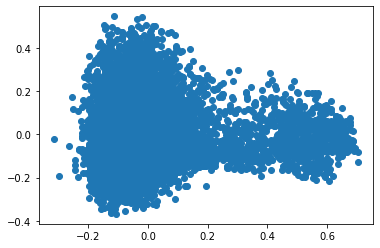

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.scatter(*vls_2d.T)

In [10]:
new_vectors = {w:v.tolist() for w, v in zip(stemmed_word_list, vls_2d)}

In [13]:
len(new_vectors)

7080

In [11]:
new_vectors_json = {"vectors": new_vectors}

In [12]:
json.dump(new_vectors_json, open("new_wordvecs10000.json", "w"))

In [23]:
step_mapping = {s:w for s, w in zip(reversed(stemmed_word_list), reversed(word_list))}

In [24]:
json.dump(step_mapping, open("stem_mapping.json", "w"))